In [ ]:
import kagglehub
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.cluster import KMeans
from xgboost import XGBClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import silhouette_score
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc

# Data Preprocessing

In [ ]:
path = kagglehub.dataset_download("jpacse/datasets-for-churn-telecom")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/datasets-for-churn-telecom


In [ ]:
files = os.listdir(path)
print("Files in the path: %s" % files)

Files in the path: ['cell2celltrain.csv', 'cell2cellholdout.csv']


In [ ]:
path = os.path.join(path, files[0])
cell2cell_data = pd.read_csv(path)
cell2cell_df = pd.DataFrame(cell2cell_data)
cell2cell_df

NameError: name 'os' is not defined

In [ ]:
cell2cell_df.isnull().sum()

,0
CustomerID,0
Churn,0
MonthlyRevenue,156
MonthlyMinutes,156
TotalRecurringCharge,156
DirectorAssistedCalls,156
OverageMinutes,156
RoamingCalls,156
PercChangeMinutes,367
PercChangeRevenues,367


In [ ]:
cell2cell_df.columns

Index(['CustomerID', 'Churn', 'MonthlyRevenue', 'MonthlyMinutes',
       'TotalRecurringCharge', 'DirectorAssistedCalls', 'OverageMinutes',
       'RoamingCalls', 'PercChangeMinutes', 'PercChangeRevenues',
       'DroppedCalls', 'BlockedCalls', 'UnansweredCalls', 'CustomerCareCalls',
       'ThreewayCalls', 'ReceivedCalls', 'OutboundCalls', 'InboundCalls',
       'PeakCallsInOut', 'OffPeakCallsInOut', 'DroppedBlockedCalls',
       'CallForwardingCalls', 'CallWaitingCalls', 'MonthsInService',
       'UniqueSubs', 'ActiveSubs', 'ServiceArea', 'Handsets', 'HandsetModels',
       'CurrentEquipmentDays', 'AgeHH1', 'AgeHH2', 'ChildrenInHH',
       'HandsetRefurbished', 'HandsetWebCapable', 'TruckOwner', 'RVOwner',
       'Homeownership', 'BuysViaMailOrder', 'RespondsToMailOffers',
       'OptOutMailings', 'NonUSTravel', 'OwnsComputer', 'HasCreditCard',
       'RetentionCalls', 'RetentionOffersAccepted', 'NewCellphoneUser',
       'NotNewCellphoneUser', 'ReferralsMadeBySubscriber', 'IncomeGro

In [ ]:
numerical_features = cell2cell_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = cell2cell_df.select_dtypes(include=['object']).columns.tolist()

print("Numerical Features:", numerical_features)
print("Categorical Features:", categorical_features)


NameError: name 'cell2cell_df' is not defined

In [ ]:
# Step 1: Handle Missing Values

num_imputer = SimpleImputer(strategy="median")
cell2cell_df[numerical_features] = num_imputer.fit_transform(cell2cell_df[numerical_features])

cat_imputer = SimpleImputer(strategy="most_frequent")
cell2cell_df[categorical_features] = cat_imputer.fit_transform(cell2cell_df[categorical_features])

In [ ]:
# Step 2: Encode Categorical Features

label_encoders = {}
for col in categorical_features:
  le = LabelEncoder()
  cell2cell_df[col] = le.fit_transform(cell2cell_df[col])
  label_encoders[col] = le

In [ ]:
# Step 3: Normalize numerical features for fair Chi-square test

scaler = MinMaxScaler()
cell2cell_df[numerical_features] = scaler.fit_transform(cell2cell_df[numerical_features])

# Chi-square scores computation

In [ ]:
excluded_columns = ["Churn", "CustomerID", "ServiceArea"]
X = cell2cell_df[numerical_features + categorical_features].drop(columns=excluded_columns, errors='ignore')
y = cell2cell_df['Churn']
chi2_scores, p_values = chi2(X, y)

In [ ]:
chi2_results = pd.DataFrame({"Feature": X.columns, "Chi-Square Score": chi2_scores, "p-value": p_values})
chi2_results = chi2_results.sort_values(by="Chi-Square Score", ascending=False)
top_features = chi2_results["Feature"].head(20).tolist()
chi2_results['Feature'].head(20)

,Feature
50,MadeCallToRetentionTeam
51,CreditRating
49,HandsetPrice
29,RetentionCalls
26,CurrentEquipmentDays
35,HandsetRefurbished
30,RetentionOffersAccepted
36,HandsetWebCapable
41,RespondsToMailOffers
40,BuysViaMailOrder


In [ ]:
def print_metrics(model_name, accuracy, precision, recall, f1, auc):
    print(f"\n=== {model_name} Metrics ===")
    print(f"Accuracy: {accuracy:.2f}%")
    print(f"Precision: {precision:.2f}%")
    print(f"Recall: {recall:.2f}%")
    print(f"F1-Score: {f1:.2f}%")
    print(f"AUC: {auc:.2f}%")

# Without Smote

In [ ]:
X = cell2cell_df[top_features]
y = cell2cell_df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

**Logistic Regression**

In [ ]:
# Define and fit the model
lr_model = LogisticRegression(
    penalty='l2',
    C=0.1,
    class_weight='balanced',
    solver='liblinear'
)
lr_model.fit(X_train_scaled, y_train)

# Get predicted probabilities
y_prob_lr = lr_model.predict_proba(X_test_scaled)[:, 1]

# Threshold tuning using F1-score
prec, rec, thresholds = precision_recall_curve(y_test, y_prob_lr)
f1_scores = 2 * prec * rec / (prec + rec)
best_threshold = thresholds[np.argmax(f1_scores)]

# Predict using best threshold
y_pred_tuned = (y_prob_lr > best_threshold).astype(int)

# Evaluate using tuned predictions
accuracy = accuracy_score(y_test, y_pred_tuned) * 100
precision = precision_score(y_test, y_pred_tuned) * 100
recall = recall_score(y_test, y_pred_tuned) * 100
f1 = f1_score(y_test, y_pred_tuned) * 100
auc_lr = roc_auc_score(y_test, y_prob_lr) * 100

# Display results
print_metrics("Logistic Regression", accuracy, precision, recall, f1, auc_lr)



=== Logistic Regression Metrics ===
Accuracy: 50.72%
Precision: 32.97%
Recall: 70.99%
F1-Score: 45.02%
AUC: 59.28%


**Decision Tree**

In [ ]:
dt_model = DecisionTreeClassifier(
    criterion='entropy',
    min_samples_split=50,
    max_depth=10,
    class_weight='balanced',
    random_state=42
)
dt_model.fit(X_train_scaled, y_train)

y_pred = dt_model.predict(X_test_scaled)
y_prob_dt = dt_model.predict_proba(X_test_scaled)[:, 1]

prec, rec, thresholds = precision_recall_curve(y_test, y_prob_dt)
f1_scores = 2 * prec * rec / (prec + rec + 1e-6)
best_threshold = thresholds[np.argmax(f1_scores)]

y_pred_tuned = (y_prob_dt > best_threshold).astype(int)

accuracy = accuracy_score(y_test, y_pred_tuned) * 100
precision = precision_score(y_test, y_pred_tuned) * 100
recall = recall_score(y_test, y_pred_tuned) * 100
f1 = f1_score(y_test, y_pred_tuned) * 100
auc_dt = roc_auc_score(y_test, y_prob_dt) * 100

print_metrics("Decision Tree (Threshold Tuned)", accuracy, precision, recall, f1, auc_dt)



=== Decision Tree (Threshold Tuned) Metrics ===
Accuracy: 49.36%
Precision: 33.29%
Recall: 77.84%
F1-Score: 46.64%
AUC: 62.19%


**Random Forest**

In [ ]:
rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=4,
    class_weight='balanced',
    random_state=42
)
rf_model.fit(X_train_scaled, y_train)

y_pred = rf_model.predict(X_test_scaled)
y_prob_rf = rf_model.predict_proba(X_test_scaled)[:, 1]
y_pred_adjusted = np.where(y_prob_rf > 0.4, 1, 0)

accuracy = accuracy_score(y_test, y_pred) * 100
precision = precision_score(y_test, y_pred_adjusted) * 100
recall = recall_score(y_test, y_pred_adjusted) * 100
f1 = f1_score(y_test, y_pred_adjusted) * 100
auc_rf = roc_auc_score(y_test, y_prob_rf) * 100

print_metrics("Random Forest", accuracy, precision, recall, f1, auc_rf)


=== Random Forest Metrics ===
Accuracy: 58.55%
Precision: 33.12%
Recall: 85.29%
F1-Score: 47.72%
AUC: 64.18%


**Naive Bayes**

In [ ]:
nb_model = GaussianNB()
nb_model.fit(X_train_scaled, y_train)

y_pred = nb_model.predict(X_test_scaled)
y_prob_nb = nb_model.predict_proba(X_test_scaled)[:, 1]
y_pred_adjusted = np.where(y_prob_nb > 0.6, 1, 0)

accuracy = accuracy_score(y_test, y_pred) * 100
precision_adj = precision_score(y_test, y_pred_adjusted) * 100
recall_adj = recall_score(y_test, y_pred_adjusted) * 100
f1_adj = f1_score(y_test, y_pred_adjusted) * 100
auc_nb = roc_auc_score(y_test, y_prob_nb) * 100

print_metrics("Naive Bayes", accuracy, precision, recall, f1, auc_nb)


=== Naive Bayes Metrics ===
Accuracy: 68.81%
Precision: 33.12%
Recall: 85.29%
F1-Score: 47.72%
AUC: 56.96%


**Adaboost**

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve
import numpy as np

# Base learner with more depth (can capture more patterns)
base_estimator = DecisionTreeClassifier(max_depth=3, min_samples_split=10)

# Modified AdaBoost model
ada_model = AdaBoostClassifier(
    estimator=base_estimator,
    n_estimators=200,           # More estimators
    learning_rate=0.5,          # Slightly reduced to prevent overfitting
    random_state=42
)
ada_model.fit(X_train_scaled, y_train)

# Get predicted probabilities
y_prob_ada = ada_model.predict_proba(X_test_scaled)[:, 1]

# Find optimal threshold for best F1-score
prec, rec, thresholds = precision_recall_curve(y_test, y_prob_ada)
f1_scores = 2 * prec * rec / (prec + rec + 1e-6)
best_threshold = thresholds[np.argmax(f1_scores)]

# Adjust predictions using optimal threshold
y_pred_adjusted = (y_prob_ada > best_threshold).astype(int)

# Evaluate
accuracy = accuracy_score(y_test, (y_prob_ada > 0.5).astype(int)) * 100  # standard accuracy at 0.5 threshold
precision = precision_score(y_test, y_pred_adjusted) * 100
recall = recall_score(y_test, y_pred_adjusted) * 100
f1 = f1_score(y_test, y_pred_adjusted) * 100
auc_ada = roc_auc_score(y_test, y_prob_ada) * 100

print_metrics("AdaBoost (Tuned)", accuracy, precision, recall, f1, auc_ada)



=== AdaBoost (Tuned) Metrics ===
Accuracy: 72.01%
Precision: 33.24%
Recall: 83.01%
F1-Score: 47.47%
AUC: 64.08%


**XGBoost**

In [ ]:
xgb_model = XGBClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=3,  # Approx. ratio of negative to positive examples
    random_state=42,
    use_label_encoder=False,
    eval_metric="logloss"
)

xgb_model.fit(X_train_scaled, y_train)

y_prob_xgb = xgb_model.predict_proba(X_test_scaled)[:, 1]

# Get optimal threshold for best F1-score
prec, rec, thresholds = precision_recall_curve(y_test, y_prob_xgb)
with np.errstate(divide='ignore', invalid='ignore'):
    f1_scores = 2 * prec * rec / (prec + rec)
    f1_scores[np.isnan(f1_scores)] = 0
best_thresh = thresholds[np.argmax(f1_scores)]

# Get predicted probabilities
y_prob_xgb = xgb_model.predict_proba(X_test_scaled)[:, 1]

# Manual threshold (try 0.3 or 0.35 to improve recall)
threshold = 0.35
y_pred_xgb = (y_prob_xgb > threshold).astype(int)

# Evaluation metrics
accuracy = accuracy_score(y_test, y_pred_xgb) * 100
precision = precision_score(y_test, y_pred_xgb, zero_division=0) * 100
recall = recall_score(y_test, y_pred_xgb) * 100
f1 = f1_score(y_test, y_pred_xgb) * 100
auc_xgb = roc_auc_score(y_test, y_prob_xgb) * 100

print_metrics("XGBoost (Tuned Threshold)", accuracy, precision, recall, f1, auc_xgb)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:40:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



=== XGBoost (Tuned Threshold) Metrics ===
Accuracy: 35.81%
Precision: 30.20%
Recall: 95.93%
F1-Score: 45.93%
AUC: 64.77%


**Stacking ensemble**

In [ ]:
# Base learners
estimators = [
    ('lr', LogisticRegression(C=0.01, penalty='l2', solver='liblinear', class_weight='balanced', random_state=42)),
    ('rf', RandomForestClassifier(n_estimators=300, max_depth=10, min_samples_split=10, min_samples_leaf=4, class_weight='balanced', random_state=42)),
    ('nb', GaussianNB()),
    ('ada', AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1), n_estimators=100, learning_rate=0.5, random_state=42)),
    ('xgb', XGBClassifier(n_estimators=200, learning_rate=0.05, max_depth=4, subsample=0.8, colsample_bytree=0.8, random_state=42, eval_metric="logloss"))
]

# Meta-learner
final_estimator = LogisticRegression(class_weight='balanced', solver='liblinear', random_state=42)

# Stacking Classifier
stacking_model = StackingClassifier(
    estimators=estimators,
    final_estimator=final_estimator,
    passthrough=True,
    cv=5,
    n_jobs=-1
)

# Fit the model
stacking_model.fit(X_train_scaled, y_train)

# Predict probabilities and adjust threshold
y_prob_stack = stacking_model.predict_proba(X_test_scaled)[:, 1]
y_pred_stack = np.where(y_prob_stack > 0.4, 1, 0)

# Metrics
accuracy = accuracy_score(y_test, y_pred_stack) * 100
precision = precision_score(y_test, y_pred_stack) * 100
recall = recall_score(y_test, y_pred_stack) * 100
f1 = f1_score(y_test, y_pred_stack) * 100
auc = roc_auc_score(y_test, y_prob_stack) * 100

print_metrics("Stacking Ensemble", accuracy, precision, recall, f1, auc)



=== Stacking Ensemble Metrics ===
Accuracy: 47.54%
Precision: 33.27%
Recall: 84.08%
F1-Score: 47.67%
AUC: 64.72%


**ROC Curves**

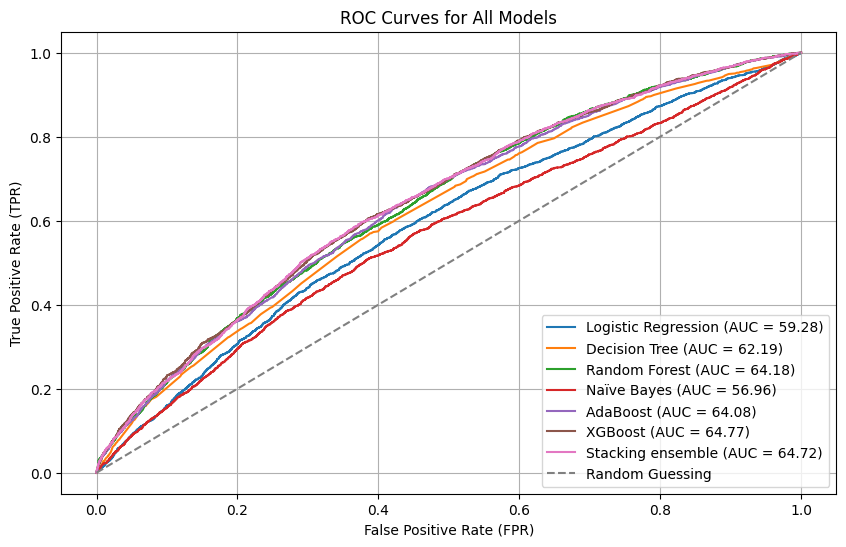

In [ ]:
from sklearn.metrics import auc  # Re-import in case it was overwritten

models = {
    "Logistic Regression": y_prob_lr,
    "Decision Tree": y_prob_dt,
    "Random Forest": y_prob_rf,
    "Naïve Bayes": y_prob_nb,
    "AdaBoost": y_prob_ada,
    "XGBoost": y_prob_xgb,
    "Stacking ensemble": y_prob_stack
}

plt.figure(figsize=(10, 6))

for model_name, y_prob in models.items():
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc*100:.2f})")

plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Guessing")

plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curves for All Models")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# With smote

In [ ]:
print("Class distribution before SMOTE:")
print(y.value_counts())

Class distribution before SMOTE:
Churn
0    36336
1    14711
Name: count, dtype: int64


In [ ]:
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)

print("Class distribution after SMOTE:")
print(np.bincount(y_smote))

Class distribution after SMOTE:
[36336 36336]


In [ ]:
X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(
    X_smote, y_smote, test_size=0.2, random_state=42
)

In [ ]:
scaler = StandardScaler()
X_train_smote_scaled = scaler.fit_transform(X_train_smote)
X_test_smote_scaled = scaler.transform(X_test_smote)

**Linear Regression**

In [ ]:
# Define and fit the model
lr_model = LogisticRegression(
    penalty='l2',
    C=0.1,
    class_weight='balanced',
    solver='liblinear'
)
lr_model.fit(X_train_smote_scaled, y_train_smote)

# Get predicted probabilities
y_prob_lr = lr_model.predict_proba(X_test_smote_scaled)[:, 1]

# Threshold tuning using F1-score
prec, rec, thresholds = precision_recall_curve(y_test_smote, y_prob_lr)
f1_scores = 2 * prec * rec / (prec + rec)
best_threshold = thresholds[np.argmax(f1_scores)]

# Predict using best threshold
y_pred_tuned = (y_prob_lr > best_threshold).astype(int)

# Evaluate using tuned predictions
accuracy = accuracy_score(y_test_smote, y_pred_tuned) * 100
precision = precision_score(y_test_smote, y_pred_tuned) * 100
recall = recall_score(y_test_smote, y_pred_tuned) * 100
f1 = f1_score(y_test_smote, y_pred_tuned) * 100
auc_lr = roc_auc_score(y_test_smote, y_prob_lr) * 100

# Display results
print_metrics("Logistic Regression", accuracy, precision, recall, f1, auc_lr)



=== Logistic Regression Metrics ===
Accuracy: 51.20%
Precision: 50.79%
Recall: 98.72%
F1-Score: 67.08%
AUC: 59.78%


**Decision Tree**

In [ ]:
dt_model = DecisionTreeClassifier(
    criterion='entropy',
    min_samples_split=50,
    max_depth=10,
    class_weight='balanced',
    random_state=42
)
dt_model.fit(X_train_smote_scaled, y_train_smote)

y_pred = dt_model.predict(X_test_smote_scaled)
y_prob_dt = dt_model.predict_proba(X_test_smote_scaled)[:, 1]

prec, rec, thresholds = precision_recall_curve(y_test_smote, y_prob_dt)
f1_scores = 2 * prec * rec / (prec + rec + 1e-6)
best_threshold = thresholds[np.argmax(f1_scores)]

y_pred_tuned = (y_prob_dt > best_threshold).astype(int)

accuracy = accuracy_score(y_test_smote, y_pred_tuned) * 100
precision = precision_score(y_test_smote, y_pred_tuned) * 100
recall = recall_score(y_test_smote, y_pred_tuned) * 100
f1 = f1_score(y_test_smote, y_pred_tuned) * 100
auc_dt = roc_auc_score(y_test_smote, y_prob_dt) * 100

print_metrics("Decision Tree (Threshold Tuned)", accuracy, precision, recall, f1, auc_dt)



=== Decision Tree (Threshold Tuned) Metrics ===
Accuracy: 63.84%
Precision: 60.20%
Recall: 83.21%
F1-Score: 69.86%
AUC: 74.49%


**Random Forest**

In [ ]:
rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=4,
    class_weight='balanced',
    random_state=42
)
rf_model.fit(X_train_smote_scaled, y_train_smote)

y_pred = rf_model.predict(X_test_smote)
y_prob_rf = rf_model.predict_proba(X_test_smote_scaled)[:, 1]
y_pred_adjusted = np.where(y_prob_rf > 0.4, 1, 0)

accuracy = accuracy_score(y_test_smote, y_pred) * 100
precision = precision_score(y_test_smote, y_pred_adjusted) * 100
recall = recall_score(y_test_smote, y_pred_adjusted) * 100
f1 = f1_score(y_test_smote, y_pred_adjusted) * 100
auc_rf = roc_auc_score(y_test_smote, y_prob_rf) * 100

print_metrics("Random Forest", accuracy, precision, recall, f1, auc_rf)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(



=== Random Forest Metrics ===
Accuracy: 50.35%
Precision: 59.57%
Recall: 88.14%
F1-Score: 71.09%
AUC: 75.88%


**Naive Bayes**

In [ ]:
nb_model = GaussianNB()
nb_model.fit(X_train_smote_scaled, y_train_smote)

y_pred = nb_model.predict(X_test_smote_scaled)
y_prob_nb = nb_model.predict_proba(X_test_smote_scaled)[:, 1]
y_pred_adjusted = np.where(y_prob_nb > 0.6, 1, 0)

accuracy = accuracy_score(y_test_smote, y_pred) * 100
precision_adj = precision_score(y_test_smote, y_pred_adjusted) * 100
recall_adj = recall_score(y_test_smote, y_pred_adjusted) * 100
f1_adj = f1_score(y_test_smote, y_pred_adjusted) * 100
auc_nb = roc_auc_score(y_test_smote, y_prob_nb) * 100

print_metrics("Naive Bayes", accuracy, precision, recall, f1, auc_nb)


=== Naive Bayes Metrics ===
Accuracy: 56.46%
Precision: 59.57%
Recall: 88.14%
F1-Score: 71.09%
AUC: 58.47%


**Adaboost**

In [ ]:
ada_model = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=50,
    learning_rate=1.0,
    random_state=42
)
ada_model.fit(X_train_smote_scaled, y_train_smote)

y_pred = ada_model.predict(X_test_smote_scaled)
y_prob_ada = ada_model.predict_proba(X_test_smote_scaled)[:, 1]

accuracy = accuracy_score(y_test_smote, y_pred) * 100
precision = precision_score(y_test_smote, y_pred) * 100
recall = recall_score(y_test_smote, y_pred) * 100
f1 = f1_score(y_test_smote, y_pred) * 100
auc_ada = roc_auc_score(y_test_smote, y_prob_ada) * 100

print_metrics("Adaboost", accuracy, precision, recall, f1, auc_ada)


=== Adaboost Metrics ===
Accuracy: 64.00%
Precision: 63.82%
Recall: 65.80%
F1-Score: 64.80%
AUC: 69.40%


**XGBoost**

In [ ]:
xgb_model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric="logloss"
)
xgb_model.fit(X_train_smote_scaled, y_train_smote)

y_pred = xgb_model.predict(X_test_smote_scaled)
y_prob_xgb = xgb_model.predict_proba(X_test_smote_scaled)[:, 1]

accuracy = accuracy_score(y_test_smote, y_pred) * 100
precision = precision_score(y_test_smote, y_pred) * 100
recall = recall_score(y_test_smote, y_pred) * 100
f1 = f1_score(y_test_smote, y_pred) * 100
auc_xgb = roc_auc_score(y_test_smote, y_prob_xgb) * 100

print_metrics("XGBoost", accuracy, precision, recall, f1, auc_xgb)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:44:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



=== XGBoost Metrics ===
Accuracy: 72.21%
Precision: 75.42%
Recall: 66.46%
F1-Score: 70.66%
AUC: 79.91%


In [ ]:
# Base learners
estimators = [
    ('lr', LogisticRegression(C=0.01, penalty='l2', solver='liblinear', class_weight='balanced', random_state=42)),
    ('rf', RandomForestClassifier(n_estimators=300, max_depth=10, min_samples_split=10, min_samples_leaf=4, class_weight='balanced', random_state=42)),
    ('nb', GaussianNB()),
    ('ada', AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1), n_estimators=100, learning_rate=0.5, random_state=42)),
    ('xgb', XGBClassifier(n_estimators=200, learning_rate=0.05, max_depth=4, subsample=0.8, colsample_bytree=0.8, random_state=42, eval_metric="logloss"))
]

# Meta-learner
final_estimator = LogisticRegression(class_weight='balanced', solver='liblinear', random_state=42)

# Stacking Classifier
stacking_model = StackingClassifier(
    estimators=estimators,
    final_estimator=final_estimator,
    passthrough=True,
    cv=5,
    n_jobs=-1
)

# Fit the model
stacking_model.fit(X_train_smote_scaled, y_train_smote)

# Predict probabilities and adjust threshold
y_prob_stack = stacking_model.predict_proba(X_test_smote_scaled)[:, 1]
y_pred_stack = np.where(y_prob_stack > 0.4, 1, 0)

# Metrics
accuracy = accuracy_score(y_test_smote, y_pred_stack) * 100
precision = precision_score(y_test_smote, y_pred_stack) * 100
recall = recall_score(y_test_smote, y_pred_stack) * 100
f1 = f1_score(y_test_smote, y_pred_stack) * 100
auc = roc_auc_score(y_test_smote, y_prob_stack) * 100

print_metrics("Stacking Ensemble", accuracy, precision, recall, f1, auc)



=== Stacking Ensemble Metrics ===
Accuracy: 69.75%
Precision: 67.31%
Recall: 77.61%
F1-Score: 72.09%
AUC: 79.12%


**ROC Curves**

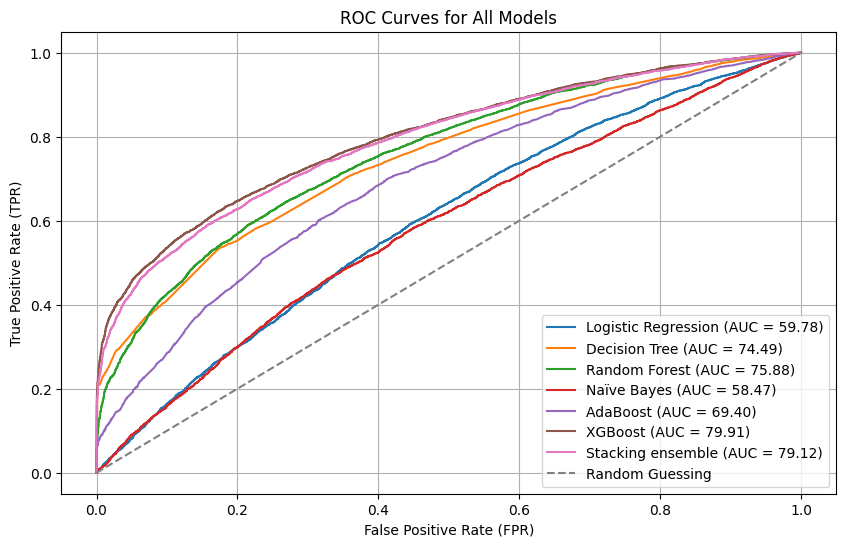

In [ ]:
from sklearn.metrics import auc

models = {
    "Logistic Regression": y_prob_lr,
    "Decision Tree": y_prob_dt,
    "Random Forest": y_prob_rf,
    "Naïve Bayes": y_prob_nb,
    "AdaBoost": y_prob_ada,
    "XGBoost": y_prob_xgb,
    "Stacking ensemble": y_prob_stack
}

plt.figure(figsize=(10, 6))

for model_name, y_prob in models.items():
    fpr, tpr, _ = roc_curve(y_test_smote, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc*100:.2f})")

plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Guessing")

plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curves for All Models")
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [ ]:
for model_name, y_prob in models.items():
    print(f"{model_name}: y_test_smote = {len(y_test_smote)}, y_prob = {len(y_prob)}")


Logistic Regression: y_test_smote = 14535, y_prob = 14535
Decision Tree: y_test_smote = 14535, y_prob = 14535
Random Forest: y_test_smote = 14535, y_prob = 14535
Naïve Bayes: y_test_smote = 14535, y_prob = 14535
AdaBoost: y_test_smote = 14535, y_prob = 14535
XGBoost: y_test_smote = 14535, y_prob = 14535
